<a href="https://colab.research.google.com/github/KamiraPagulayan/CCMACLRL_EXERCISES_COM222ML/blob/main/EXERCISE_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [94]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [95]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


<ipython-input-96-0ff15b4ddab4>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count =pd.value_counts(df_train["label"], sort= True)


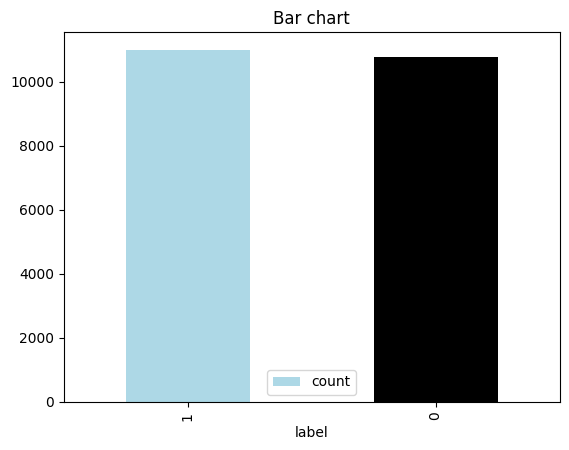

In [96]:
import matplotlib.pyplot as plt
count =pd.value_counts(df_train["label"], sort= True)
count.plot(kind= 'bar', color= ["lightblue", "black"])
plt.title('Bar chart')
plt.legend(loc='best')
plt.show()

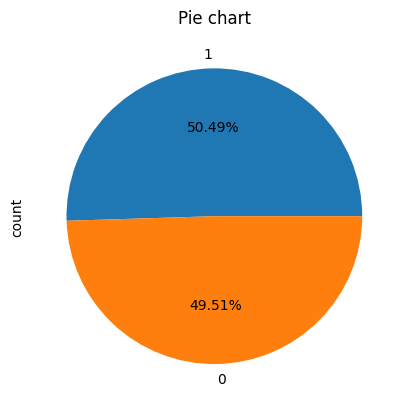

In [97]:
count.plot(kind = 'pie',autopct='%1.2f%%') # 1.2 is the decimal points for 2 places
plt.title('Pie chart')
plt.show()

In [98]:
#check for missing data
print("Missing data in each column:\n" + str(df_train.isnull().sum()))

Missing data in each column:
text     0
label    0
dtype: int64


In [99]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


**Validation Set**

Use this set to evaluate your model

In [100]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [101]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

<ipython-input-102-7a02c2e581c5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_train['label'], palette = 'rocket')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


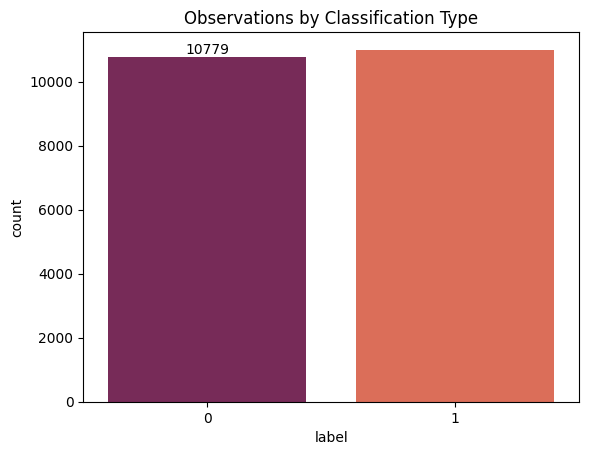

In [102]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = df_train['label'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [103]:
tagalog = [["sakin", "saking", "ako'y", "alinman", "ama", "aminin", "aming-aming", "angking", "ano-ano", "anumang-ito"],
    ["tatlo", "at saka", "ating-atin", "ating-atin", "ayaw", "babaan", "bago-bago", "bakit nga", "bawat isa", "bilang ng"],
    ["dahil sa", "dalawahan", "dapat na", "din naman", "dito lamang", "doon sa", "gagawin ito", "subalit", "ginagawa na", "ginawa na"],
    ["ginawang-kawani", "gumagawa", "gusto ko", "habang-buhay", "hanggang dito", "hindi ito", "huwag na", "iba pang", "ibaba ang", "ibabaw ng"],
    ["ibig sabihin", "ikaw'y", "ilagay mo", "ilalim ng", "ilan pa", "inyong-aming", "isa sa", "isang pagkakataon", "itaas na", "ito'y"],
    ["iyo'y", "iyon na", "iyong sarili", "kaibigan", "kahit na", "kailangan ko", "kailan man", "kami'y", "kanilang-amin", "kanino man"],
    ["kanya-kanyang", "kanyang-kanyang", "kapag may", "kapwa-tao", "karamihan sa", "katiyakan ng", "katulad nito", "kaya naman", "kaysa sa", "ko'y"],
    ["kong-kong", "kulang pa", "kumuha ng", "kung sino", "labanan", "lahat-lahat", "lamang ito", "likuran", "lima-limang", "maaari bang"],
    ["maaaring gawin", "maging ito", "mahusay na", "makita mo", "marami pang", "marapat na", "masyadong marami", "mayroon pa", "mga ganitong", "minsan pa"],
    ["mismo itong", "mula sa", "muli na", "na dito", "nabanggit na", "naging bahagi", "nagkaroon ng", "nais ko", "nakita na", "namin ang"],
    ["napaka-saya", "narito na", "nasaan ka", "ngunit", "ngayon din", "ni siya", "nila ito", "nilang lahat", "nito'y", "niya'y"],
    ["niyang lahat", "noon din", "o kaya", "paano kaya", "pababa ng", "paggawa ng", "pagitan ng", "pagkakaroon ng", "pagkatapos ng", "palabas na"],
    ["pamamagitan ng", "panahon na", "pangalawang pagkakataon", "para sa", "paraan ng", "pareho ang", "pataas na", "pero ito", "pumunta na", "pumupunta rin"],
    ["sa mga", "saan man", "sabi ng", "sabihin mo", "sarili mo", "sila'y", "sino ba", "siya'y", "tatlong", "tayo'y"],
    ["tulad ng", "tungkol sa", "una sa lahat", "walang ibang"]]


2. Check how many rows and columns are in the training dataset using `.info()`

In [104]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [105]:
# Check for NaN values in the training dataset
nan_counts = df_train.isnull().sum()
print("NaN values in each column:\n", nan_counts)

NaN values in each column:
 text     0
label    0
dtype: int64


4. Check for duplicate rows

In [106]:
# Check for duplicate rows in the training dataset
duplicate_rows = df_train.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


5. Check how many rows belong to each class

In [107]:
print("Column names:", df_train.columns.tolist())

Column names: ['text', 'label']


In [108]:
print(df_train.head())

                                                text  label
0  Presidential candidate Mar Roxas implies that ...      1
1  Parang may mali na sumunod ang patalastas ng N...      1
2                    Bet ko. Pula Ang Kulay Ng Posas      1
3                               [USERNAME] kakampink      0
4  Bakit parang tahimik ang mga PINK about Doc Wi...      1


## B. Text pre-processing

6. Remove duplicate rows

In [109]:
# Remove duplicate rows
df_train_cleaned = df_train.drop_duplicates()

# Display the shape of the original and cleaned DataFrame
print("Original shape:", df_train.shape)
print("Cleaned shape:", df_train_cleaned.shape)

Original shape: (21773, 2)
Cleaned shape: (21773, 2)


7. Remove rows with NaN values

In [110]:
df_train_cleaned = df_train.dropna()

# Display the shape of the original and cleaned DataFrame
print("Original shape:", df_train.shape)
print("Cleaned shape:", df_train_cleaned.shape)

Original shape: (21773, 2)
Cleaned shape: (21773, 2)


8. Convert all text to lowercase

In [111]:
# Convert the text column to lowercase
df_train_cleaned['text'] = df_train_cleaned['text'].str.lower()

# Display the first few rows to verify the change
print(df_train_cleaned.head())

                                                text  label
0  presidential candidate mar roxas implies that ...      1
1  parang may mali na sumunod ang patalastas ng n...      1
2                    bet ko. pula ang kulay ng posas      1
3                               [username] kakampink      0
4  bakit parang tahimik ang mga pink about doc wi...      1


9. Remove digits, URLS and special characters

In [112]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove special characters (keeping only letters and whitespace)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

10. Remove stop words

In [113]:
def remove_stopwords(text):
    # Get the list of stop words for the specific language (e.g., English)
    stop_words = set(stopwords.words('english'))  # Change 'english' to your language if needed
    # Tokenize the text
    words = text.split()
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Join words back into a string
    return ' '.join(filtered_words)


In [114]:
# Remove stop words from the text column
df_train_cleaned['text'] = df_train_cleaned['text'].apply(remove_stopwords)

# Display the first few rows to verify the changes
print(df_train_cleaned.head())

                                                text  label
0  presidential candidate mar roxas implies govt ...      1
1  parang may mali na sumunod ang patalastas ng n...      1
2                    bet ko. pula ang kulay ng posas      1
3                               [username] kakampink      0
4  bakit parang tahimik ang mga pink doc willie o...      1


11. Use Stemming or Lemmatization

In [115]:
from nltk.stem import PorterStemmer

# Initialize the stemmer
stemmer = PorterStemmer()

## C. Training your model

12. Put all text training data in variable **X_train**

In [116]:
# Extract the text data into a variable X_train
X_train = df_train_cleaned['text'].values  # This will give you a NumPy array

# Display the first few entries of X_train to verify
print(X_train[:5])  # Display the first 5 entries

['presidential candidate mar roxas implies govt liable re: laglag bala. laglag bayag na ata ito'
 'parang may mali na sumunod ang patalastas ng nescaf coffee black sa commercial ni binay. parang lang naman.'
 'bet ko. pula ang kulay ng posas' '[username] kakampink'
 'bakit parang tahimik ang mga pink doc willie ong? reaction paper.']


13. Put all training data labels in variable **y_train**

In [117]:
# Check the column names in the DataFrame
print(df_train_cleaned.columns)

Index(['text', 'label'], dtype='object')


In [118]:
# Display the first few rows of the DataFrame
print(df_train_cleaned.head())

# Check the shape of the DataFrame
print("Shape of DataFrame:", df_train_cleaned.shape)

# Check the column names in the DataFrame
print("Column names:", df_train_cleaned.columns)


                                                text  label
0  presidential candidate mar roxas implies govt ...      1
1  parang may mali na sumunod ang patalastas ng n...      1
2                    bet ko. pula ang kulay ng posas      1
3                               [username] kakampink      0
4  bakit parang tahimik ang mga pink doc willie o...      1
Shape of DataFrame: (21773, 2)
Column names: Index(['text', 'label'], dtype='object')


In [119]:
# Replace 'actual_label_column_name' with the correct column name found in the previous step
y_train = df_train_cleaned['text'].values

# Display the first few entries of y_train to verify
print(y_train[:5])


['presidential candidate mar roxas implies govt liable re: laglag bala. laglag bayag na ata ito'
 'parang may mali na sumunod ang patalastas ng nescaf coffee black sa commercial ni binay. parang lang naman.'
 'bet ko. pula ang kulay ng posas' '[username] kakampink'
 'bakit parang tahimik ang mga pink doc willie ong? reaction paper.']


14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [120]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Transform the text data into numerical form
X_train_transformed = count_vectorizer.fit_transform(X_train)

# Convert to an array for easier visualization (optional)
X_train_transformed_array = X_train_transformed.toarray()

# Display the shape of the transformed data
print("Shape of X_train_transformed (CountVectorizer):", X_train_transformed.shape)


Shape of X_train_transformed (CountVectorizer): (21773, 37669)


In [121]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data into numerical form
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)

# Convert to an array for easier visualization (optional)
X_train_transformed_array = X_train_transformed.toarray()

# Display the shape of the transformed data
print("Shape of X_train_transformed (TfidfVectorizer):", X_train_transformed.shape)


Shape of X_train_transformed (TfidfVectorizer): (21773, 37669)


15. Create an instance of `MultinomalNB()`

In [122]:
# Create an instance of MultinomialNB
model = MultinomialNB()


In [123]:
# Import necessary libraries
from sklearn.naive_bayes import MultinomialNB

# Create an instance of MultinomialNB
model = MultinomialNB()

# You can now use 'model' for training and predictions
print("MultinomialNB model instance created.")


MultinomialNB model instance created.


16. Train the model using `.fit()`

In [124]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
import re

# Step 1: Load your dataset
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/unique_train_dataset.csv")

# Step 2: Clean the data
# Check for duplicates and NaN values
print("Initial DataFrame shape:", df_train.shape)
print("Duplicates in DataFrame:", df_train.duplicated().sum())
print("Missing values in each column:\n", df_train.isnull().sum())

# Remove duplicates
df_train = df_train.drop_duplicates()

# Remove rows with NaN values
df_train = df_train.dropna()

# Clean the text: convert to lowercase, remove digits, URLs, special characters
df_train['text'] = df_train['text'].str.lower()
df_train['text'] = df_train['text'].str.replace(r'\d+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'\W+', ' ', regex=True)

# Remove stop words
stop_words = set(stopwords.words('english'))  # Change language if necessary
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Step 3: Define the training variables
X_train = df_train['text']  # Use the cleaned text column
y_train = df_train['label']  # Use the actual label column name

# Step 4: Convert text data to numerical form using CountVectorizer
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

# Check if X_train_transformed is created successfully
print("Shape of X_train_transformed:", X_train_transformed.shape)

# Step 5: Create an instance of the MultinomialNB model and train it
model = MultinomialNB()
model.fit(X_train_transformed, y_train)

print("Model training complete.")


Initial DataFrame shape: (21773, 2)
Duplicates in DataFrame: 0
Missing values in each column:
 text     0
label    0
dtype: int64
Shape of X_train_transformed: (21773, 36855)
Model training complete.


## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [125]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/unique_validation_dataset.csv")

print("Initial Validation DataFrame shape:", df_validation.shape)
print("Duplicates in Validation DataFrame:", df_validation.duplicated().sum())
print("Missing values in each column:\n", df_validation.isnull().sum())

# Remove duplicates
df_validation = df_validation.drop_duplicates()

# Remove rows with NaN values
df_validation = df_validation.dropna()

# Clean the text: convert to lowercase, remove digits, URLs, special characters
df_validation['text'] = df_validation['text'].str.lower()  # Replace 'text' with actual name
df_validation['text'] = df_validation['text'].str.replace(r'\d+', '', regex=True)
df_validation['text'] = df_validation['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
df_validation['text'] = df_validation['text'].str.replace(r'\W+', ' ', regex=True)

# Remove stop words
stop_words = set(stopwords.words('english'))  # Change language if necessary
df_validation['text'] = df_validation['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Step 3: Prepare validation data
X_validation = df_validation['text']  # Use the cleaned text column
y_validation = df_validation['label']  # Use the actual label column name

# Step 4: Convert validation text data to numerical form using the same vectorizer
X_validation_transformed = vectorizer.transform(X_validation)

# Check if X_validation_transformed is created successfully
print("Shape of X_validation_transformed:", X_validation_transformed.shape)


y_validation_pred = model.predict(X_validation_transformed)


print("Predictions for the validation set:", y_validation_pred)


Initial Validation DataFrame shape: (2800, 2)
Duplicates in Validation DataFrame: 0
Missing values in each column:
 text     0
label    0
dtype: int64
Shape of X_validation_transformed: (2800, 36855)
Predictions for the validation set: [1 0 0 ... 0 0 1]


18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [126]:
df_validation = df_validation.drop_duplicates().dropna()
df_validation['text'] = df_validation['text'].str.lower().str.replace(r'\d+', '', regex=True).str.replace(r'http\S+|www\S+|https\S+', '', regex=True).str.replace(r'\W+', ' ', regex=True)

stop_words = set(stopwords.words('english'))
df_validation['text'] = df_validation['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Prepare validation data
X_validation = df_validation['text']
y_validation = df_validation['label']  # Put all validation data labels here

# Use the model to predict
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

print("Predictions for the validation set:", y_validation_pred)

Predictions for the validation set: [1 0 0 ... 0 0 1]


19. Create a confusion matrix using the **validation dataset**

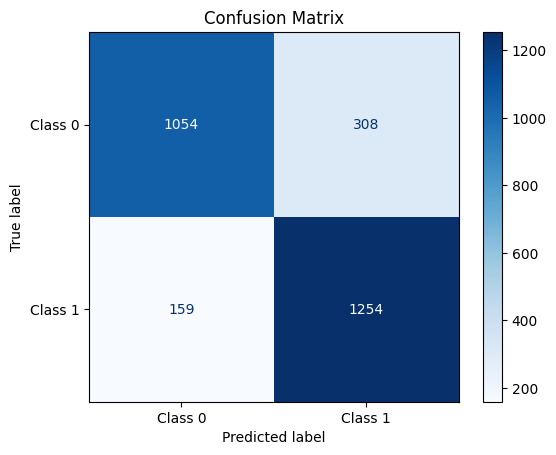

In [127]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Generate confusion matrix
cm = confusion_matrix(y_validation, y_validation_pred)

# Step 2: Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])  # Replace with your actual class labels

# Step 3: Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [128]:
import pandas as pd

# Step 1: Load the test dataset
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/unique_test_dataset.csv")

# Step 2: Clean the test data
df_test = df_test.drop_duplicates().dropna()
df_test['text'] = df_test['text'].str.lower().str.replace(r'\d+', '', regex=True).str.replace(r'http\S+|www\S+|https\S+', '', regex=True).str.replace(r'\W+', ' ', regex=True)

# Remove stop words
stop_words = set(stopwords.words('english'))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Step 3: Prepare test data
X_test = df_test['text']

# Step 4: Convert test text data to numerical form using the same vectorizer
X_test_transformed = vectorizer.transform(X_test)

# Step 5: Use the model to predict
y_test_pred = model.predict(X_test_transformed)

# Output predictions
print("Predictions for the test set:", y_test_pred)


Predictions for the test set: [1 0 1 ... 1 0 1]


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Put all test data labels in y_test variable
y_test = df_test['label']  # Replace with the actual column name for labels

# Step 2: Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_test, y_test_pred, average='weighted')  # Use 'macro' or 'micro' as needed
f1 = f1_score(y_test, y_test_pred, average='weighted')  # Use 'macro' or 'micro' as needed

# Step 3: Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1 Score: 0.83


22. Create a confusion matrix using the **test dataset**

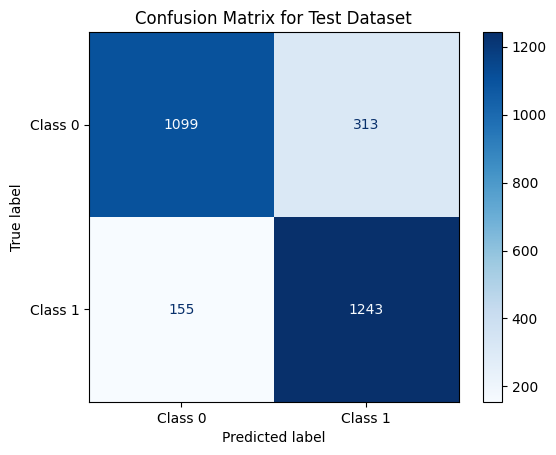

In [130]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Class 0', 'Class 1'])  # Replace with your actual class labels

disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Dataset")
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [131]:
input = ["I love programming"]

input_cleaned = [text.lower() for text in input]

# Remove digits, URLs, and special characters
input_cleaned = [re.sub(r'\d+', '', text) for text in input_cleaned]
input_cleaned = [re.sub(r'http\S+|www\S+|https\S+', '', text) for text in input_cleaned]
input_cleaned = [re.sub(r'\W+', ' ', text) for text in input_cleaned]

# Remove stop words
input_cleaned = [' '.join(word for word in text.split() if word not in stop_words) for text in input_cleaned]

# Step 3: Convert the cleaned input to numerical form using the same vectorizer
input_transformed = vectorizer.transform(input_cleaned)

# Step 4: Predict the label using the model
prediction = model.predict(input_transformed)

# Step 5: Print the prediction
print("Predicted label for non-hate speech input:", prediction[0])


Predicted label for non-hate speech input: 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [132]:
import re

# Step 1: Create a hate speech input
hate_speech_input = ["Ang init ng ulo ko ang gulo-gulo bg paligid ang sarap talaga sumigaw ng Putangina."]

# Step 2: Preprocess the input
# Convert to lowercase
hate_speech_input_cleaned = [text.lower() for text in hate_speech_input]

# Remove digits, URLs, and special characters
hate_speech_input_cleaned = [re.sub(r'\d+', '', text) for text in hate_speech_input_cleaned]
hate_speech_input_cleaned = [re.sub(r'http\S+|www\S+|https\S+', '', text) for text in hate_speech_input_cleaned]
hate_speech_input_cleaned = [re.sub(r'\W+', ' ', text) for text in hate_speech_input_cleaned]

# Assuming stop_words has been defined earlier
# Remove stop words
hate_speech_input_cleaned = [' '.join(word for word in text.split() if word not in stop_words) for text in hate_speech_input_cleaned]

# Step 3: Convert the cleaned input to numerical form using the same vectorizer
hate_speech_input_transformed = vectorizer.transform(hate_speech_input_cleaned)

# Step 4: Predict the label using the model
prediction_hate_speech = model.predict(hate_speech_input_transformed)

# Step 5: Print the prediction
print("Predicted label for hate speech input:", prediction_hate_speech[0])


Predicted label for hate speech input: 1
